# 1D Burgers

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/en/physics_driven/mindspore_burgers1D.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindflow/en/physics_driven/mindspore_burgers1D.py)&emsp;[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_en/physics_driven/burgers1D.ipynb)

This notebook requires **MindSpore version >= 2.0.0** to support new APIs including: *mindspore.jit, mindspore.jit_class, mindspore.jacrev*.

## Overview

Computational fluid dynamics is one of the most important techniques in the field of fluid mechanics in the 21st century. The flow analysis, prediction and control can be realized by solving the governing equations of fluid mechanics by numerical method. Traditional finite element method (FEM) and finite difference method (FDM) are inefficient because of the complex simulation process (physical modeling, meshing, numerical discretization, iterative solution, etc.) and high computing costs. Therefore, it is necessary to improve the efficiency of fluid simulation with AI.

In recent years, while the development of classical theories and numerical methods with computer performance tends to be smooth, machine learning methods combine a large amount of data with neural networks realize the flow field's fast simulation. These methods can obtain the accuracy close to the traditional methods, which provides a new idea for flow field solution.

Burgers' equation is a nonlinear partial differential equation that simulates the propagation and reflection of shock waves. It is widely used in the fields of fluid mechanics, nonlinear acoustics, gas dynamics et al. It is named after Johannes Martins Hamburg (1895-1981). In this case, MindSpore Flow fluid simulation suite is used to solve the Burgers' equation in one-dimensional viscous state based on the physical-driven PINNs (Physics Informed Neural Networks) method.

## Problem Description

The form of Burgers' equation is as follows:

$$
u_t + uu_x = \epsilon u_{xx}, \quad x \in[-1,1], t \in[0, T],
$$

where $\epsilon=0.01/\pi$, the left of the equal sign is the convection term, and the right is the dissipation term. In this case, the Dirichlet boundary condition and the initial condition of the sine function are used. The format is as follows:

$$
u(t, -1) = u(t, 1) = 0,
$$

$$
u(0, x) = -sin(\pi x).
$$

In this case, the PINNs method is used to learn the mapping $(x, t) \mapsto u$ from position and time to corresponding physical quantities. So that the solution of Burgers' equation is realized.

## Technology Path

The specific process of MindSpore Flow for solving the problem is as follows:

1. Training Dataset Construction.
2. Model Construction.
3. Optimizer.
4. Burgers1D.
5. Model Training.
6. Model Evaluation and Visualization.

In [1]:
import time

import numpy as np
import sympy

import mindspore
from mindspore import nn, ops, Tensor, jit, set_seed
from mindspore import dtype as mstype
from mindspore import load_checkpoint, load_param_into_net

The following `src` pacakage can be downloaded in [applications/physics_driven/burgers/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/physics_driven/burgers/src).

In [2]:
from mindflow.pde import Burgers, sympy_to_mindspore
from mindflow.cell import MultiScaleFCCell
from mindflow.utils import load_yaml_config

from src import create_training_dataset, create_test_dataset, visual, calculate_l2_error

set_seed(123456)
np.random.seed(123456)

In [3]:
# set context for training: using graph mode for high performance training with GPU acceleration
mindspore.set_context(mode=mindspore.GRAPH_MODE, device_target="GPU", device_id=4)
use_ascend = mindspore.get_context(attr_key='device_target') == "Ascend"

In [4]:
# load configurations
config = load_yaml_config('burgers_cfg.yaml')

## Training Dataset Construction

In this case, random sampling is performed according to the solution domain, initial condition and boundary value condition to generate training data sets. The specific settings are as follows:

Download the test dataset: [physics_driven/burgers_pinns/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/physics_driven/burgers_pinns/dataset/).

In [5]:
# create training dataset
burgers_train_dataset = create_training_dataset(config)
train_dataset = burgers_train_dataset.create_dataset(batch_size=config["train_batch_size"],
                                                     shuffle=True,
                                                     prebatched_data=True,
                                                     drop_remainder=True)
# create test dataset
inputs, label = create_test_dataset()

## Model Construction

This example uses a simple fully-connected network with a depth of 6 layers and the activation function is the `tanh` function.

In [6]:
# define models and optimizers
model = MultiScaleFCCell(in_channels=config["model"]["in_channels"],
                         out_channels=config["model"]["out_channels"],
                         layers=config["model"]["layers"],
                         neurons=config["model"]["neurons"],
                         residual=config["model"]["residual"],
                         act=config["model"]["activation"],
                         num_scales=1)
if config["load_ckpt"]:
    param_dict = load_checkpoint(config["load_ckpt_path"])
    load_param_into_net(model, param_dict)


## Optimizer

In [7]:
# define optimizer
optimizer = nn.Adam(model.trainable_params(), config["optimizer"]["initial_lr"])

## Burgers1D

The following `Burgers1D` defines the burgers' problem. Specifically, it includes 3 parts: governing equation, initial condition and boundary conditions.


In [8]:
class Burgers1D(Burgers):
    def __init__(self, model, loss_fn=nn.MSELoss()):
        super(Burgers1D, self).__init__(model, loss_fn=loss_fn)
        self.ic_nodes = sympy_to_mindspore(self.ic(), self.in_vars, self.out_vars)
        self.bc_nodes = sympy_to_mindspore(self.bc(), self.in_vars, self.out_vars)

    def ic(self):
        ic_eq = self.u + sympy.sin(np.pi * self.x)
        equations = {"ic": ic_eq}
        return equations

    def bc(self):
        bc_eq = self.u
        equations = {"bc": bc_eq}
        return equations

    def get_loss(self, pde_data, ic_data, bc_data):
        pde_res = self.parse_node(self.pde_nodes, inputs=pde_data)
        pde_loss = self.loss_fn(pde_res[0], Tensor(np.array([0.0]), mstype.float32))

        ic_res = self.parse_node(self.ic_nodes, inputs=ic_data)
        ic_loss = self.loss_fn(ic_res[0], Tensor(np.array([0.0]), mstype.float32))

        bc_res = self.parse_node(self.bc_nodes, inputs=bc_data)
        bc_loss = self.loss_fn(bc_res[0], Tensor(np.array([0.0]), mstype.float32))

        return pde_loss + ic_loss + bc_loss

## Model Training

With **MindSpore version >= 2.0.0**, we can use the functional programming for training neural networks.

In [9]:
def train():
    '''Train and evaluate the network'''
    problem = Burgers1D(model)

    if use_ascend:
        from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
        loss_scaler = DynamicLossScaler(1024, 2, 100)
        auto_mixed_precision(model, 'O1')
    else:
        loss_scaler = None

    # the loss function receives 3 data sources: pde, ic and bc
    def forward_fn(pde_data, ic_data, bc_data):
        loss = problem.get_loss(pde_data, ic_data, bc_data)
        if use_ascend:
            loss = loss_scaler.scale(loss)

        return loss

    grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    # using jit function to accelerate training process
    @jit
    def train_step(pde_data, ic_data, bc_data):
        loss, grads = grad_fn(pde_data, ic_data, bc_data)
        if use_ascend:
            loss = loss_scaler.unscale(loss)
            if all_finite(grads):
                grads = loss_scaler.unscale(grads)

        loss = ops.depend(loss, optimizer(grads))
        return loss

    epochs = config["train_epochs"]
    steps_per_epochs = train_dataset.get_dataset_size()
    sink_process = mindspore.data_sink(train_step, train_dataset, sink_size=1)
    for epoch in range(1, 1 + epochs):
        # train
        time_beg = time.time()
        model.set_train(True)
        for _ in range(steps_per_epochs):
            step_train_loss = sink_process()
        print(f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg)*1000 :.3f} ms")
        model.set_train(False)
        if epoch % config["eval_interval_epochs"] == 0:
            calculate_l2_error(model, inputs, label, config["train_batch_size"])

In [10]:
start_time = time.time()
train()
print("End-to-End total time: {} s".format(time.time() - start_time))

burgers: u(x, t)*Derivative(u(x, t), x) + Derivative(u(x, t), t) - 0.00318309897556901*Derivative(u(x, t), (x, 2))
    Item numbers of current derivative formula nodes: 3
ic: u(x, t) + sin(3.14159265358979*x)
    Item numbers of current derivative formula nodes: 2
bc: u(x, t)
    Item numbers of current derivative formula nodes: 1


epoch: 100 train loss: 0.42995507 epoch time: 63.536 ms
    predict total time: 243.24369430541992 ms
    l2_error:  0.8788317251751688
epoch: 200 train loss: 0.41935205 epoch time: 62.145 ms
    predict total time: 7.87043571472168 ms
    l2_error:  0.88964679457787
epoch: 300 train loss: 0.42547783 epoch time: 62.736 ms
    predict total time: 7.727861404418945 ms
    l2_error:  0.8895206005088669
epoch: 400 train loss: 0.4227412 epoch time: 62.124 ms
    predict total time: 7.363557815551758 ms
    l2_error:  0.8889956873924331
epoch: 500 train loss: 0.41943315 epoch time: 62.960 ms
    predict total time: 4.832983016967773 ms
    l2_error:  0.8881562175445344
...
epoch: 14600 train loss: 0.00013843024 epoch time: 62.264 ms
predict total time: 5.646228790283203 ms
l2_error:  0.004415987361258303
epoch: 14700 train loss: 7.498202e-05 epoch time: 62.589 ms
    predict total time: 5.714178085327148 ms
    l2_error:  0.004421070906100957
epoch: 14800 train loss: 0.00018732375 epoch time

## Model Evaluation and Visualization

After training, all data points in the flow field can be inferred. And related results can be visualized.

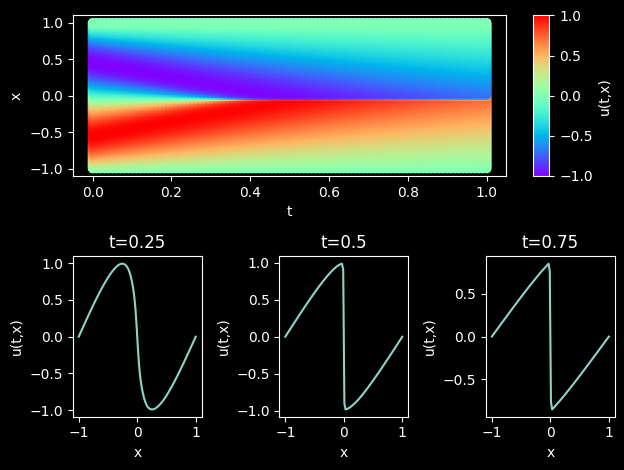

In [11]:
# visualization
epochs = config["train_epochs"]
visual(model, epochs=epochs, resolution=config["visual_resolution"])